# Sentiment Analysis with Keras: Deep Learning Model

Reference: https://realpython.com/python-keras-text-classification/

## Libraries

In [59]:
import pandas as pd
import numpy as np
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt


## Parameters

In [2]:
current_path = getcwd()

## 0. Data Ingest

In [3]:
filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []

for source, filepath in filepath_dict.items():
    
    df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [4]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


## Bag Of Words Model (BOW)

This is a common method in NLP to represent sentences (documents) as vectors.
Each word is assigned an int value, then the frecuency of that word in the sentence is counted. 

Scikit-learn.feature_extraction.text provides the following vectorizers, 
to extract the vocabulary out of a corpus data set:

1. CountVectorizer() 
2. HashingVectorizer()
3. TfidfVectorizer()

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. 
It additionally removes punctuation and special characters and can apply other preprocessing to each word. 

Another approach, is to use the custom tokenizer from the NLTK library with the CountVectorizer or use other customizations to improve the performance of the model.

Reference: https://en.wikipedia.org/wiki/Bag-of-words_model

In [5]:
sentences = ['John likes ice cream', 'John hates chocolate.']

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [6]:
# This means that both sentences have one occurrence of John, which is in the first place in the vocabulary.
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

## 1. Baseline Model - Logistic Regression

In [7]:
# Filter data set for "yelp"
df_yelp = df[df['source'] == 'yelp']

# Get values as numpy arrays
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

# Split up training and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a new CountVectorizer object
vectorizer = CountVectorizer()

# Vectorize training data set
vectorizer.fit(sentences_train)

# Transform both training and test data
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [9]:
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

### Apply Logistic Regression Classifier  for yelp

In [10]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
score = logistic_reg.score(X_test, y_test)

print("Accuracy:", score)

# Print Confusion Matrix
Pred_Y = logistic_reg.predict(X_test)

print("\n Confusion Matrix")
confusion_matrix(y_test, Pred_Y)/len(Pred_Y)

Accuracy: 0.796

 Confusion Matrix


array([[0.4  , 0.08 ],
       [0.124, 0.396]])

### Apply logistic Regression Classifier for all

In [11]:
for source in df['source'].unique():
    
    # Filter for every data source type
    df_source = df[df['source'] == source]
    
    # Get x and y values as np arrays
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    # Split up training and test data sets
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    # Create a new CountVectorizer Object
    # Let model learn the vocab
    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    
    # Transform training and test X set ( Apply vectorization)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    # Fit model and calculate score
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    score = log_reg.score(X_test, y_test)
    
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Implementing Deep Neural Networks

In [12]:
# Number of features
input_dim = X_train.shape[1]  
print(input_dim)

2505


In [13]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25060     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the neural networks model
%timeit
history = model.fit(X_train, y_train,
                     epochs=30,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=10)

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7807


In [17]:
plt.style.use('ggplot')

def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

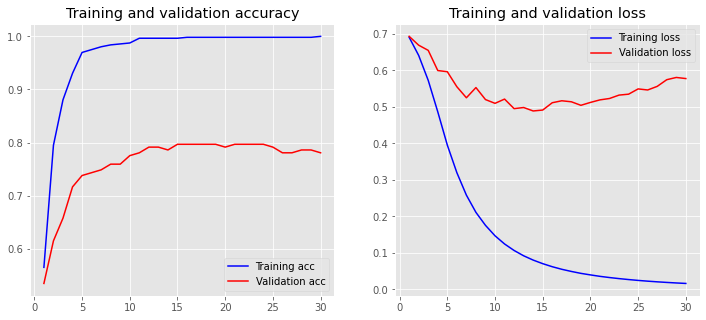

In [18]:
plot_history(history)

## Representing Words as Vector

### One Hot Encoding

it is simply done by taking a vector of the length of the vocabulary with an entry for each word in the corpus.

In [19]:
# Example
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']

# Label Encoder from Scikit Learn
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)


Using this representation, we can use the **OneHotEncoder** provided by scikit-learn to encode the categorical values we got before into a one-hot encoded numeric array. OneHotEncoder expects each categorical value to be in a separate row.

In [20]:
city_labels.reshape((5, 1))

array([[1],
       [0],
       [0],
       [2],
       [1]], dtype=int64)

In [21]:
encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Word Embedding

This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions. 

This means representing words as an n-length vector. So that when two words are close in semactic meaning i.e. "Hamburguer" and "hotdog", then they also are geometrically close to each other but far away from a word like "Ferrari". This would allow to compute correlation between words, like in the following app https://embeddings.macheads101.com/word?word=purple. Therefore vector arithmetic should be possible, for example **King - Man + Woman = Queen**.

Note that the word embeddings do not understand the text as a human would, but they rather map the statistical structure of the language used in the corpus. Their aim is to map semantic meaning into a geometric space. This geometric space is then called the **embedding space**.

Reference : https://www.youtube.com/watch?v=5PL0TmQhItY&ab_channel=macheads101

In [22]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


The indexing is ordered after the most common words in the text, which you can see by the word the having the index 1. It is important to note that the index 0 is reserved and is not assigned to any word.

Unknown words (words that are not in the vocabulary) are denoted in Keras with word_count + 1 since they can also hold some information. You can see the index of each word by taking a look at the word_index dictionary of the Tokenizer object

In [23]:
for word in ['the', 'all', 'bad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
bad: 30


With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [24]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
print(X_train[0, :])

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer

Now we can use the Embedding Layer of Keras which takes the previously calculated integers and maps them to a dense vector of the embedding. You will need the following parameters:

- input_dim: the size of the vocabulary
- output_dim: the size of the dense vector
- input_length: the length of the sequence (sentence)

With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer

In [26]:
vocab_size*50

128750

In [27]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))

# Flatten layers coverts any nxn matrix to a 1xn vector 
# so that the dense layer can take is as input 
# Referece : https://www.youtube.com/watch?v=RpC9SbHuV6E&ab_channel=TheAIUniversity
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           128750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.6310


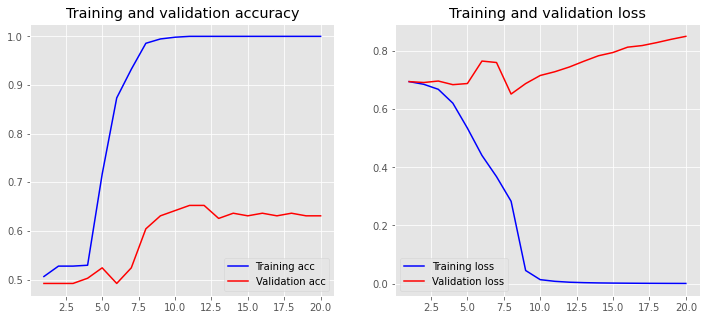

In [28]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

## Using GlobalMaxPool1D Hidden Layer

In [29]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7807


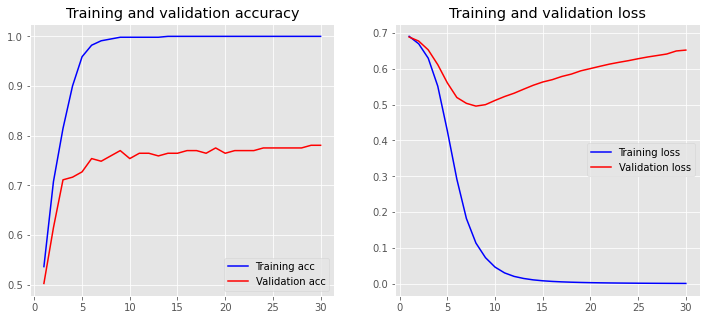

In [30]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Using Pretrained Word-Embedding

An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are Word2Vec developed by Google and GloVe (Global Vectors for Word Representation) developed by the Stanford NLP Group.

Note that those are different approaches with the same goal. Word2Vec achieves this by employing neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases you are dealing with dimensionality reduction, but Word2Vec is more accurate and GloVe is faster to compute.

In [41]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [42]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Semillero Data Science/Deep Learning/pre-trained Word Embeddings/GloVe/glove.6B.50d.txt',
     word_index = tokenizer.word_index, 
     embedding_dim = embedding_dim)

In [43]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.21705   ,  0.46515   , -0.46757001, ..., -0.043782  ,
         0.41012999,  0.1796    ],
       ...,
       [-0.44764999,  0.15226001, -0.43832001, ..., -0.65898001,
        -0.27647999,  0.89168   ],
       [ 0.11566   ,  0.099637  , -0.31233999, ..., -0.20395   ,
        -0.20169   ,  0.95064002],
       [-0.3811    ,  1.14390004,  0.22861999, ..., -0.59213001,
        -0.24017   ,  0.77824003]])

 **Vocabulary coverage** Check out how many embedding vectors are non-zero. 

In [44]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

## Run GlobMaxPool1D Hidden Layer - with no Embedding Training

In [47]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7843
Testing Accuracy:  0.7594


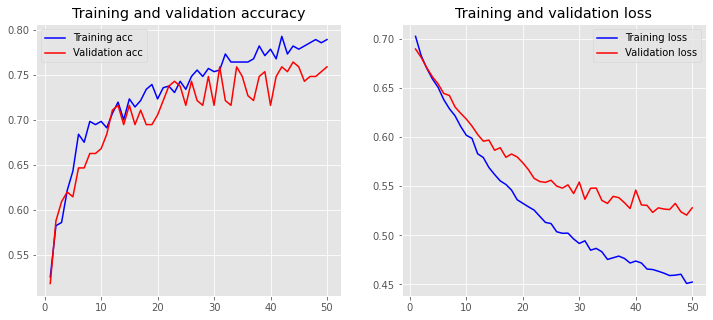

In [48]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Run GlobMaxPool1D Hidden Layer - with Emmbedding Training

In [51]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7540


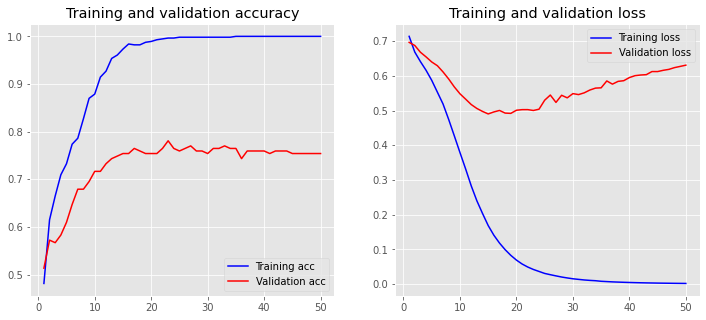

In [52]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Convolutional Neural Networks

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

Reference: 
 - Convolution -- https://en.wikipedia.org/wiki/Convolution
 - Feature Visualization -- https://distill.pub/2017/feature-visualization/

Friendly Explanation of CNN - https://www.youtube.com/watch?v=2-Ol7ZB0MmU&ab_channel=LuisSerrano

<center>
<img src="img/CNN1.jpg" aligment ='center' width="400" height="200">
    
<img src="img/CNN2.jpg" aligment ='center' width="400" height="200">
    


<center>
<img src="img/CNN3.jpg" aligment ='center' width="400" height="200">
    
<img src="img/CNN4.jpg" aligment ='center' width="400" height="200">

In [54]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7647


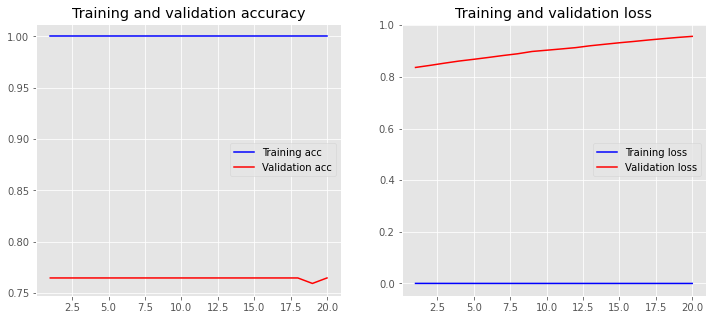

In [57]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

We can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:

- There are not enough training samples
- The data you have does not generalize well
- Missing focus on tweaking the hyperparameters

CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

## Hyperparameter Optimization - Random Search

In [61]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [62]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [63]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    
    print('Running grid search for data set :', source)
      
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.1min finished


finished amazon; write to file and proceed? [y/n] y


Running amazon data set
Best Accuracy : 0.8258
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8297


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.3min finished


finished imdb; write to file and proceed? [y/n] y


Running imdb data set
Best Accuracy : 0.8190
{'vocab_size': 4603, 'num_filters': 128, 'maxlen': 100, 'kernel_size': 5, 'embedding_dim': 50}
Test Accuracy : 0.8239


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.2min finished


finished yelp; write to file and proceed? [y/n] y


Running yelp data set
Best Accuracy : 0.8273
{'vocab_size': 4603, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}
Test Accuracy : 0.8341


